# Documentation

**Author:** Anirudh  
**Date:** 09/04/2025  

### Modification Details:
- **Model Change:** Replacing Linear Mixed Models (LMM) with Ordinary Least Squares (OLS).
- **Predictors Update:** Including each sleep variable, ICV, Gender, and other relevant variables as predictors.
- **Outcome Update:** Separating outcomes into two categories:
    - MRI variables.
    - Cognitive test variables.
- **Variables change:** Replacing Adjusted Age to AGE
- **Additional changes:** Changing the groupby function for the OLS results (instead of grouping by Outcome and feature, grouped by model)
    - Added model name = outcome + feature
    - Changed the formula to have sleep variable + features instead of features + sleep variable
    - ICV is irrelevant to cognitive outcomes, so removed it for the cognitive outcomes
    - Instead of normalizing for ICV, using ICV as covariate instead
    - Check for the insomnia categorization
    - Added Diagnoses and changed formula to have sleep variable + features instead of features + sleep variable

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
adnimerge = pd.read_csv("Imp_Files/ADNIMERGE_07Jan2024.csv")
ICV_info = adnimerge[['VISCODE','ICV','RID']]

C:\Users\anisr\AppData\Local\Temp\ipykernel_19872\879423613.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  adnimerge = pd.read_csv("Imp_Files/ADNIMERGE_07Jan2024.csv")


In [ ]:
sleep_data = pd.read_csv('Longitudinal sleep.csv')
volumes_data = pd.read_csv('Volumes_merge.csv')

In [4]:
volumes_data = volumes_data.drop(['Month', 'Years_bl'],axis=1)
sleep_data.rename(columns={"VISCODE2": "VISCODE"}, inplace=True)

In [5]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
mri_vars = ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal', 'LeftParsOpercularis', 'LeftParsOrbitalis', 'LeftParsTriangularis', 'LeftPericalcarine', 'LeftPostcentral', 'LeftPosteriorCingulate', 'LeftPrecentral', 'LeftPrecuneus', 'LeftRostralAnteriorCingulate', 'LeftRostralMiddleFrontal',
            'LeftSuperiorFrontal', 'LeftSuperiorParietal', 'LeftSuperiorTemporal', 'LeftSupramarginal', 'LeftTemporalPole', 'LeftTransverseTemporal', 'LeftUnknown', 'RightBankssts', 'RightCaudalAnteriorCingulate', 'RightCaudalMiddleFrontal', 'RightCuneus', 'RightEntorhinal', 'RightFrontalPole', 'RightFusiform', 'RightInferiorParietal', 'RightInferiorTemporal', 'RightIsthmusCingulate', 'RightLateralOccipital', 'RightLateralOrbitofrontal', 'RightLingual', 'RightMedialOrbitofrontal', 'RightMiddleTemporal', 'FourthVentricle', 'Icv', 'LeftAccumbensArea', 'LeftAmygdala', 'LeftCaudate', 'LeftCerebellumCortex', 'LeftCerebellumWM', 'LeftCerebralCortex', 'LeftCerebralWM', 'LeftChoroidPlexus', 'LeftHemisphere', 'LeftHippocampus', 'LeftInferiorLateralVentricle', 'LeftLateralVentricle', 'LeftPallidum', 'LeftPutamen', 'LeftThalamus', 'LeftVentralDC', 'LeftVessel', 'NonWMHypoIntensities', 'OpticChiasm', 'RightAccumbensArea', 'RightAmygdala', 'RightCaudate', 'RightCerebellumCortex', 'RightCerebellumWM', 'RightCerebralCortex', 'RightCerebralWM', 'RightChoroidPlexus', 'RightHemisphere', 'RightHippocampus', 'RightInferiorLateralVentricle', 'RightLateralVentricle', 'RightPallidum', 'RightPutamen', 'RightThalamus', 'RightVentralDC', 'ThirdVentricle', 'WMHypoIntensities']

In [6]:
volumes_data = pd.merge(volumes_data, ICV_info, on = ['RID','VISCODE'])

In [7]:
continuous_vars = cognitive_outcomes + mri_vars
constant_vars = ['ICV', 'PTGENDER', 'Adjusted_Age','PTEDUCAT']

In [8]:
volumes_data.columns[volumes_data.isnull().any()]


Index(['DX', 'ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN', 'ADNI_EF2'], dtype='object')

In [9]:
volumes_data.at[1819, 'DX'] = 'Dementia'

In [10]:
volumes_data.fillna(method='ffill', inplace=True)

In [11]:
from sklearn.preprocessing import LabelEncoder

categorical_columns_sleep = ['Sleep_Quality','VISCODE']

label_encoders = {}

for column in volumes_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    volumes_data[column] = le.fit_transform(volumes_data[column].astype(str))
    label_encoders[column] = le

for column in categorical_columns_sleep:
    le = LabelEncoder()
    sleep_data[column] = le.fit_transform(sleep_data[column].astype(str))
    label_encoders[column] = le

In [12]:
label_encoders

{'VISCODE': LabelEncoder(),
 'DX_bl': LabelEncoder(),
 'PTGENDER': LabelEncoder(),
 'PTETHCAT': LabelEncoder(),
 'PTRACCAT': LabelEncoder(),
 'PTMARRY': LabelEncoder(),
 'DX': LabelEncoder(),
 'Sleep_Quality': LabelEncoder()}

In [13]:
for column, encoder in label_encoders.items():
    print(f"Column: {column}")
    for encoded_value in range(len(encoder.classes_)):
        actual_value = encoder.inverse_transform([encoded_value])[0]
        print(f"Encoded value {encoded_value} corresponds to: {actual_value}")
    print()

Column: VISCODE
Encoded value 0 corresponds to: bl
Encoded value 1 corresponds to: m06
Encoded value 2 corresponds to: m12
Encoded value 3 corresponds to: m24

Column: DX_bl
Encoded value 0 corresponds to: AD
Encoded value 1 corresponds to: CN
Encoded value 2 corresponds to: LMCI

Column: PTGENDER
Encoded value 0 corresponds to: Female
Encoded value 1 corresponds to: Male

Column: PTETHCAT
Encoded value 0 corresponds to: Hisp/Latino
Encoded value 1 corresponds to: Not Hisp/Latino
Encoded value 2 corresponds to: Unknown

Column: PTRACCAT
Encoded value 0 corresponds to: Asian
Encoded value 1 corresponds to: Black
Encoded value 2 corresponds to: White

Column: PTMARRY
Encoded value 0 corresponds to: Divorced
Encoded value 1 corresponds to: Married
Encoded value 2 corresponds to: Never married
Encoded value 3 corresponds to: Unknown
Encoded value 4 corresponds to: Widowed

Column: DX
Encoded value 0 corresponds to: CN
Encoded value 1 corresponds to: Dementia
Encoded value 2 corresponds to:

In [14]:
sleep_data['NPIKSEV'].value_counts()

-4.0    1756
 1.0     217
 2.0      94
 3.0      21
Name: NPIKSEV, dtype: int64

In [15]:
sleep_data['NPIKSEV'].replace(-4.0, 0,inplace=True)

In [16]:
corr_results_volumes = []

for cont_var in continuous_vars:
    for const_var in constant_vars:
        valid_data = volumes_data[[cont_var, const_var]].dropna()
        if not valid_data.empty:  
            corr, p_val = pearsonr(valid_data[cont_var], valid_data[const_var])
            corr_results_volumes.append({
                'Dataset': 'Volumes',
                'Continuous_Variable': cont_var,
                'Constant_Variable': const_var,
                'Correlation': corr,
                'P_Value': p_val
            })

corr_df_volumes = pd.DataFrame(corr_results_volumes)

In [17]:
corr_results_sleep = []
for sleep_var in sleep_vars:
    for const_var in constant_vars:
        corr, p_val = pearsonr(
            sleep_data[sleep_var], volumes_data[const_var])
        corr_results_sleep.append({
            'Dataset': 'Sleep',
            'Continuous_Variable': sleep_var,
            'Constant_Variable': const_var,
            'Correlation': corr,
            'P_Value': p_val
        })

corr_df_sleep = pd.DataFrame(corr_results_sleep)

In [18]:
corr_df_combined = pd.concat([corr_df_volumes, corr_df_sleep], ignore_index=True)

In [19]:
from statsmodels.stats.multitest import multipletests

corr_df_combined['FDR_P_Value'] = multipletests(
    corr_df_combined['P_Value'], method='fdr_bh')[1]

In [20]:
corr_df_combined['FWER_P_Value'] = multipletests(
    corr_df_combined['P_Value'], method='bonferroni')[1]

In [21]:
corr_df_combined.sort_values(by='FDR_P_Value', ascending=True)

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
436,Volumes,RightCerebralWM,ICV,0.727570,0.000000,0.000000,0.0
368,Volumes,LeftHemisphere,ICV,0.851524,0.000000,0.000000,0.0
332,Volumes,Icv,ICV,0.999975,0.000000,0.000000,0.0
360,Volumes,LeftCerebralWM,ICV,0.719855,0.000000,0.000000,0.0
444,Volumes,RightHemisphere,ICV,0.857177,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
195,Volumes,LeftParacentral,PTEDUCAT,0.003329,0.879173,0.886151,1.0
490,Sleep,NPIKSEV,Adjusted_Age,0.002206,0.919758,0.925222,1.0
155,Volumes,LeftFrontalPole,PTEDUCAT,-0.000856,0.968834,0.972664,1.0
485,Sleep,NPIK,PTGENDER,-0.000684,0.975070,0.976993,1.0


In [22]:
corr_df_combined[corr_df_combined['FDR_P_Value'] < 0.05]

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
0,Volumes,ADNI_MEM,ICV,-0.096246,1.055212e-05,1.493169e-05,5.360475e-03
1,Volumes,ADNI_MEM,PTGENDER,-0.096763,9.453817e-06,1.341491e-05,4.802539e-03
3,Volumes,ADNI_MEM,PTEDUCAT,0.160559,1.580090e-13,3.006313e-13,8.026855e-11
4,Volumes,ADNI_EF,ICV,-0.060831,5.426797e-03,6.595246e-03,1.000000e+00
5,Volumes,ADNI_EF,PTGENDER,-0.049583,2.346875e-02,2.697313e-02,1.000000e+00
...,...,...,...,...,...,...,...
500,Sleep,Insomnia,ICV,-0.107196,9.130639e-07,1.352293e-06,4.638365e-04
501,Sleep,Insomnia,PTGENDER,-0.095752,1.171677e-05,1.653366e-05,5.952119e-03
502,Sleep,Insomnia,Adjusted_Age,0.052482,1.646915e-02,1.923294e-02,1.000000e+00
503,Sleep,Insomnia,PTEDUCAT,-0.072436,9.253301e-04,1.178114e-03,4.700677e-01


In [23]:
corr_df_combined[corr_df_combined['FWER_P_Value'] < 0.05]

,Dataset,Continuous_Variable,Constant_Variable,Correlation,P_Value,FDR_P_Value,FWER_P_Value
0,Volumes,ADNI_MEM,ICV,-0.096246,1.055212e-05,1.493169e-05,5.360475e-03
1,Volumes,ADNI_MEM,PTGENDER,-0.096763,9.453817e-06,1.341491e-05,4.802539e-03
3,Volumes,ADNI_MEM,PTEDUCAT,0.160559,1.580090e-13,3.006313e-13,8.026855e-11
6,Volumes,ADNI_EF,Adjusted_Age,-0.087635,6.078065e-05,8.233752e-05,3.087657e-02
7,Volumes,ADNI_EF,PTEDUCAT,0.223832,4.037161e-25,9.859988e-25,2.050878e-22
...,...,...,...,...,...,...,...
480,Volumes,WMHypoIntensities,ICV,0.308521,2.772331e-47,9.988257e-47,1.408344e-44
481,Volumes,WMHypoIntensities,PTGENDER,0.117552,7.165900e-08,1.148352e-07,3.640277e-05
482,Volumes,WMHypoIntensities,Adjusted_Age,0.289872,1.052231e-41,3.539954e-41,5.345331e-39
500,Sleep,Insomnia,ICV,-0.107196,9.130639e-07,1.352293e-06,4.638365e-04


In [24]:
fdr_significant_df = corr_df_combined[corr_df_combined['FDR_P_Value'] < 0.05]
fwer_significant_df = corr_df_combined[corr_df_combined['FWER_P_Value'] < 0.05]
fdr_significant_df.to_csv('supplementary_tables/FDR_Significant_Features.csv', index=False)
fwer_significant_df.to_csv('supplementary_tables/FWER_Significant_Features.csv', index=False)

In [131]:
volumes_data.to_csv('Updated_merge.csv', index=False)
sleep_data.to_csv('Updated_sleep.csv', index=False)

In [25]:
volumes_data['ICV'].mean()

1568318.1417624522

In [26]:
(volumes_data['ICV'] > volumes_data['ICV'].mean()).sum()

1004

In [27]:
volumes_data_norm = volumes_data.copy()

high_icv_threshold = volumes_data_norm['ICV'].mean()
volumes_data_norm['High_ICV'] = volumes_data_norm['ICV'] > high_icv_threshold

mri_vars_adjusted = [var for var in mri_vars if var != 'ICV']

for var in mri_vars_adjusted:
    volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
        volumes_data_norm['ICV']
volumes_data_norm.drop(columns=mri_vars_adjusted, inplace=True)

C:\Users\anisr\AppData\Local\Temp\ipykernel_18812\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
C:\Users\anisr\AppData\Local\Temp\ipykernel_18812\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volumes_data_norm[f'{var}_norm'] = volumes_data_norm[var] / \
C:\Users\anisr\AppData\Local\Temp\ipykernel_18812\2757077334.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [135]:
volumes_data_norm.to_csv("supplementary_tables/Volumes_norm_ICV.csv", index=False)

In [28]:
volumes_data

,VISCODE,RID,Brainstem,CorpusCallosumAnterior,CorpusCallosumCentral,CorpusCallosumMidAnterior,CorpusCallosumMidPosterior,CorpusCallosumPosterior,Csf,RightParacentral,...,MH2NEURL,MH4CARD,MH5RESP,MH19OTHR,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2,ICV
0,0,3,24577.0,790.0,375.0,341.0,307.0,735.0,1905.0,3539.0,...,0,1,0,0,-1.021,-1.144,-0.880,-1.368,-1.062,1920690.0
1,1,3,23784.0,774.0,378.0,358.0,314.0,701.0,2022.0,3474.0,...,0,1,0,0,-1.187,-0.674,-1.221,-1.638,-0.670,1906430.0
2,2,3,23759.0,763.0,369.0,323.0,307.0,721.0,2176.0,3234.0,...,0,1,0,0,-0.914,-0.969,-0.548,-1.837,-1.034,1903820.0
3,3,3,23324.0,717.0,351.0,317.0,319.0,707.0,2023.0,3499.0,...,0,1,0,0,-1.369,-1.511,0.739,-1.700,-1.605,1903420.0
4,0,5,22015.0,960.0,451.0,470.0,368.0,1136.0,1423.0,2862.0,...,0,0,0,0,0.743,0.165,0.739,0.259,-0.152,1640770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,1425,18719.0,477.0,291.0,267.0,282.0,740.0,1191.0,2951.0,...,0,1,0,0,-1.661,-1.078,0.739,-2.517,-0.826,1334060.0
2084,0,1427,18408.0,920.0,365.0,418.0,395.0,938.0,1534.0,3121.0,...,0,1,1,0,-0.366,-1.746,-1.530,-0.492,-2.042,1515920.0
2085,1,1427,18996.0,1001.0,392.0,438.0,348.0,902.0,1446.0,3287.0,...,0,1,1,0,-1.445,-1.642,-1.813,-1.640,-1.788,1549380.0
2086,2,1427,18506.0,917.0,363.0,388.0,391.0,937.0,1470.0,3352.0,...,0,1,1,0,-1.764,-1.625,-0.656,-0.946,-2.047,1557540.0


In [29]:
merge_norm = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [30]:
constant_vars = ['ICV', 'PTGENDER', 'Adjusted_Age', 'PTEDUCAT']
continuous_vars = cognitive_outcomes + sleep_vars + \
    mri_vars

correlation_results = []

for const_var in constant_vars:
    for cont_var in continuous_vars:
        valid_data = merge_norm[[const_var, cont_var]].dropna()

        if len(valid_data) > 0:
            corr_value, p_value = pearsonr(
                valid_data[const_var], valid_data[cont_var])

            correlation_results.append({
                'Constant_Var': const_var,
                'Continuous_Var': cont_var,
                'Correlation': corr_value,
                'P_Value': p_value
            })

correlation_results_df = pd.DataFrame(correlation_results)

In [31]:
correlation_results_df[
    (correlation_results_df['P_Value'] < 0.05) & (
        correlation_results_df['Correlation'].abs() >= 0.3)
]

,Constant_Var,Continuous_Var,Correlation,P_Value
11,ICV,Brainstem,0.618555,1.008331e-220
12,ICV,CorpusCallosumAnterior,0.367702,7.513215e-68
17,ICV,Csf,0.438307,9.247966e-99
18,ICV,RightParacentral,0.448817,4.991151e-104
20,ICV,RightParsOpercularis,0.336134,2.543413e-56
...,...,...,...,...
251,PTGENDER,RightVentralDC,0.387412,9.766994e-76
252,PTGENDER,ThirdVentricle,0.388680,2.909182e-76
268,Adjusted_Age,CorpusCallosumMidAnterior,-0.331861,7.352527e-55
350,Adjusted_Age,LeftCerebralWM,-0.336832,1.461199e-56


In [32]:
correlation_results_df[correlation_results_df['Constant_Var'] == 'ICV'].sort_values(
    by='Correlation', ascending=False).to_csv('supplementary_tables/ICV_Correlation.csv', index=False)

In [33]:
correlation_results_df[correlation_results_df['Constant_Var'].isin(
    ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT'])].to_csv('supplementary_tables/Constant_Correlation.csv', index=False)

In [ ]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictorscog = ['PTGENDER', 'AGE', 'PTEDUCAT', 'APOE4','DX_1','DX_2']
predictorsmri = ['PTGENDER', 'AGE', 'PTEDUCAT', 'APOE4','ICV','DX_1','DX_2']


In [35]:
sleep_data[sleep_data['Insomnia']==1]['RID'].unique()

array([ 352,  382,  450,  487,  568,  692,  748,  932,  934,  984, 1168,
       1280], dtype=int64)

In [36]:
print(dict(enumerate(label_encoders['DX_bl'].classes_)))
print(dict(enumerate(label_encoders['DX'].classes_)))
print(dict(enumerate(label_encoders['VISCODE'].classes_)))

{0: 'AD', 1: 'CN', 2: 'LMCI'}
{0: 'CN', 1: 'Dementia', 2: 'MCI'}
{0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}


In [40]:
categorical_vars = ['DX']
merge_norm = pd.get_dummies(
    merge_norm, columns=categorical_vars, drop_first=True)

In [59]:
OLS_results_cognitive = []
OLS_results_mri = []
model_counter = 1

def store_all_predictors_ols(model, outcome, sleep_var, predictors):
    records = []
    for predictor in predictors + [sleep_var]:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': model.params.get(predictor, float('nan')),
            'P-Value': model.pvalues.get(predictor, float('nan')),
            'R-Squared': model.rsquared
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorscog)}"
            model = smf.ols(formula, data=merge_norm).fit()

            records = store_all_predictors_ols(
                model, outcome, sleep_var, predictorscog)
            OLS_results_cognitive.extend(records)
            model_counter += 1
        except Exception as e:
            print(f"[OLS Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorsmri)}"
            model = smf.ols(formula, data=merge_norm).fit()

            records = store_all_predictors_ols(
                model, outcome, sleep_var, predictorsmri)
            OLS_results_mri.extend(records)
            model_counter += 1
        except Exception as e:
            print(f"[OLS MRI] Error for {outcome} with {sleep_var}: {e}")

In [60]:
OLS_results_cognitive_df = pd.DataFrame(OLS_results_cognitive)
OLS_results_mri_df = pd.DataFrame(OLS_results_mri)

In [62]:
flat_cog = OLS_results_cognitive_df[~OLS_results_cognitive_df['Feature'].isin(
    ['Intercept', 'Group Var'])]
flat_mri = OLS_results_mri_df[~OLS_results_mri_df['Feature'].isin(
    ['Intercept', 'Group Var'])]

In [63]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT': 'Ethnicity',
    'PTMARRY': 'Marital Status',
    'APOE4': 'APOE4',
    'BMI': 'BMI',
    'MH19OTHR': 'Other_MH',
    'MH2NEURL': 'Neurological',
    'MH4CARD': 'Cardiovascular',
    'MH5RESP': 'Respiratory',
    'MHPSYCH': 'Psychiatric'
}
flat_cog['Feature'] = OLS_results_cognitive_df['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = OLS_results_mri_df['Feature'].replace(feature_rename_map)

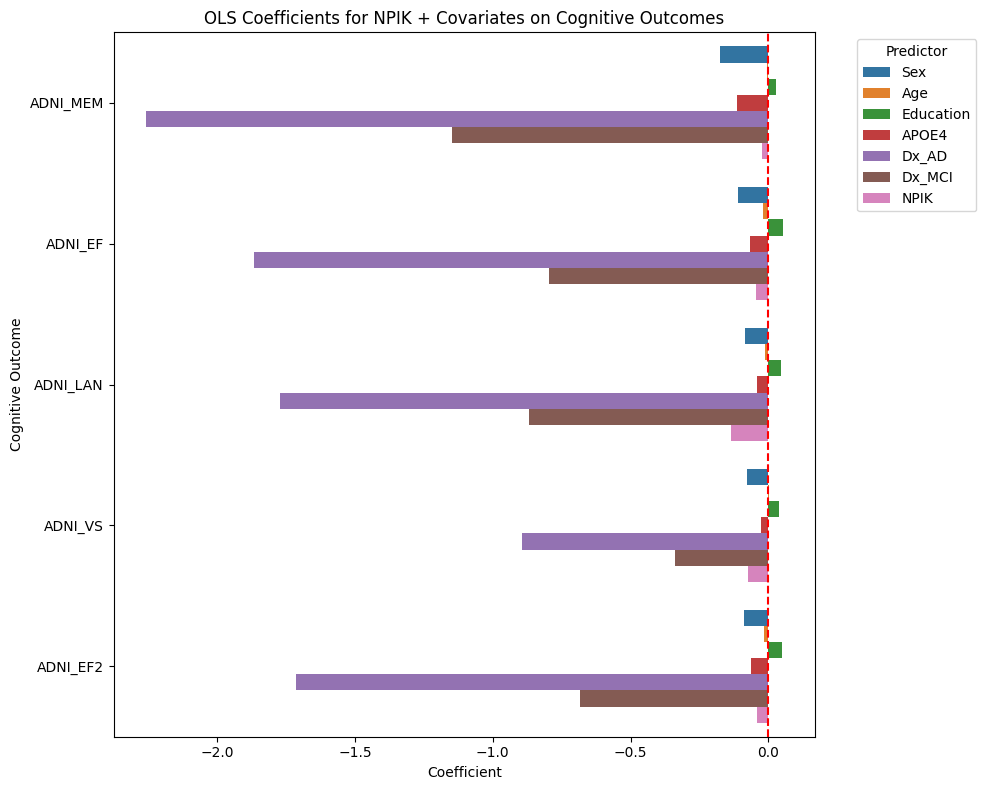

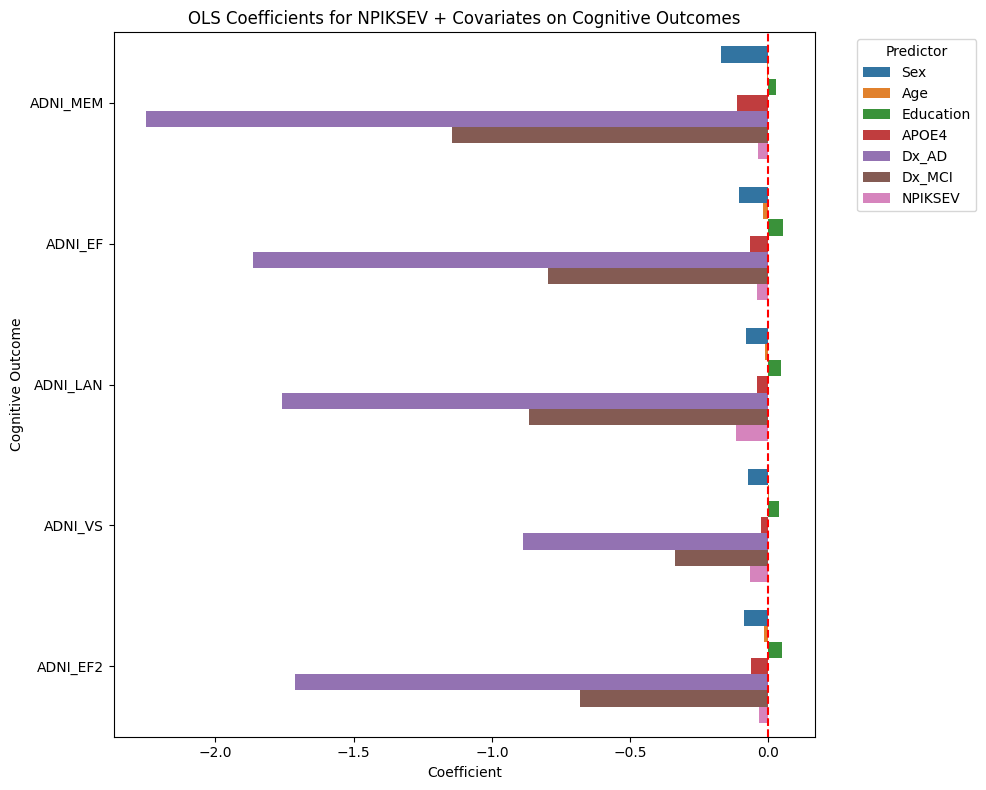

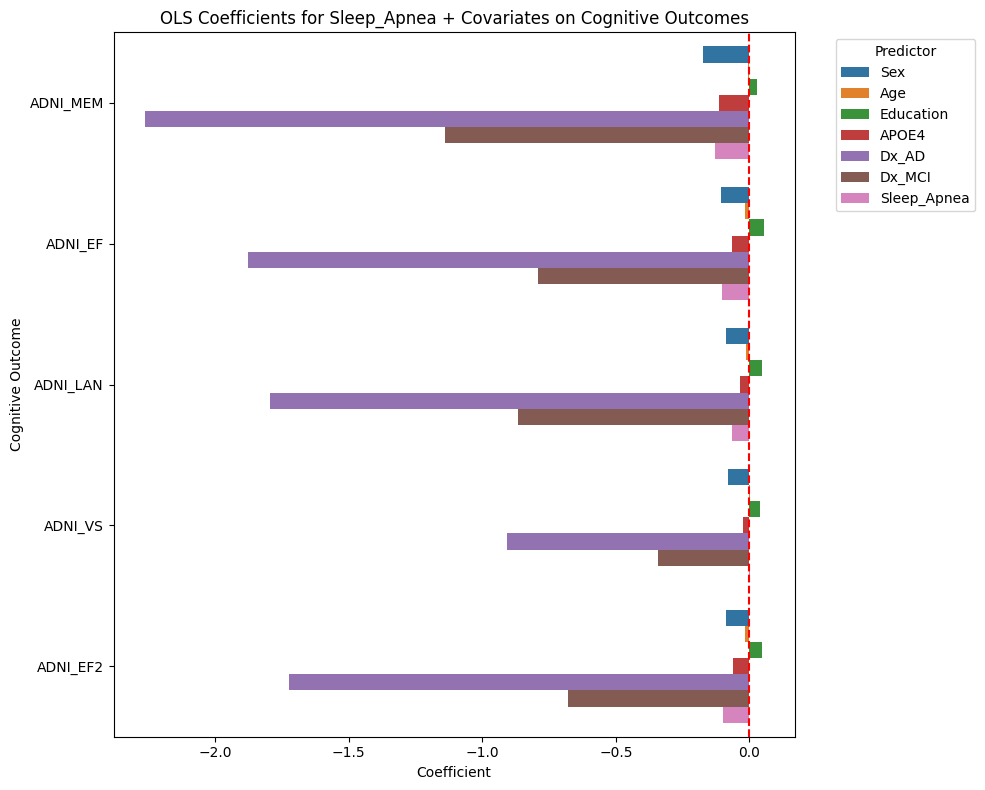

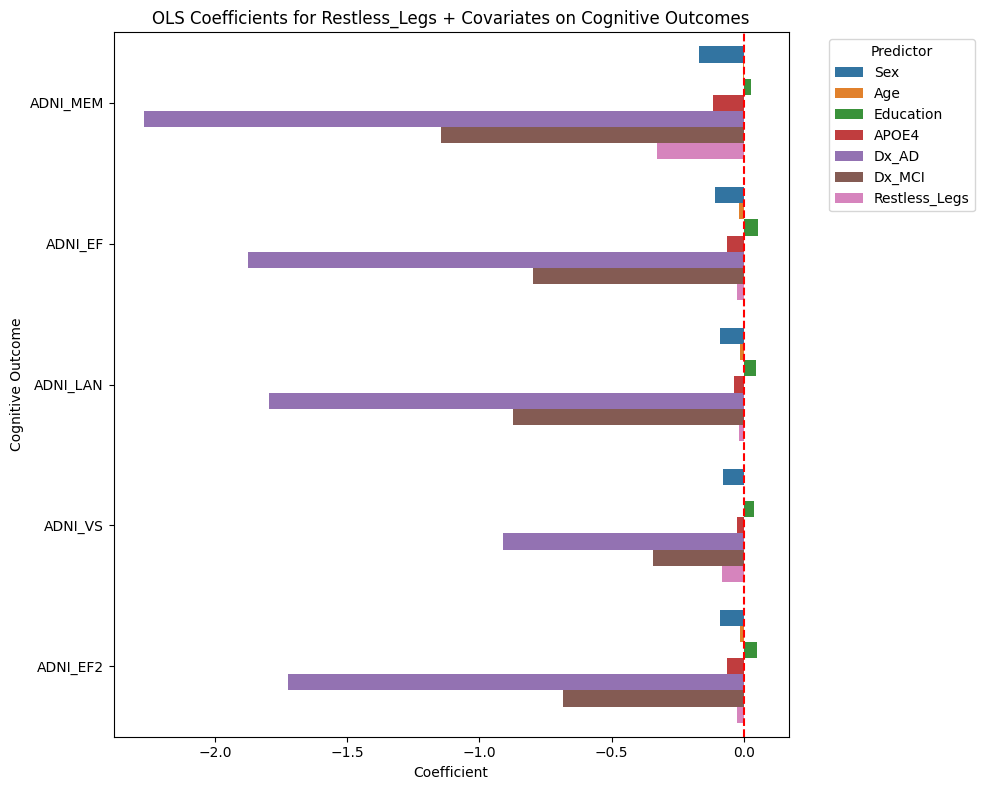

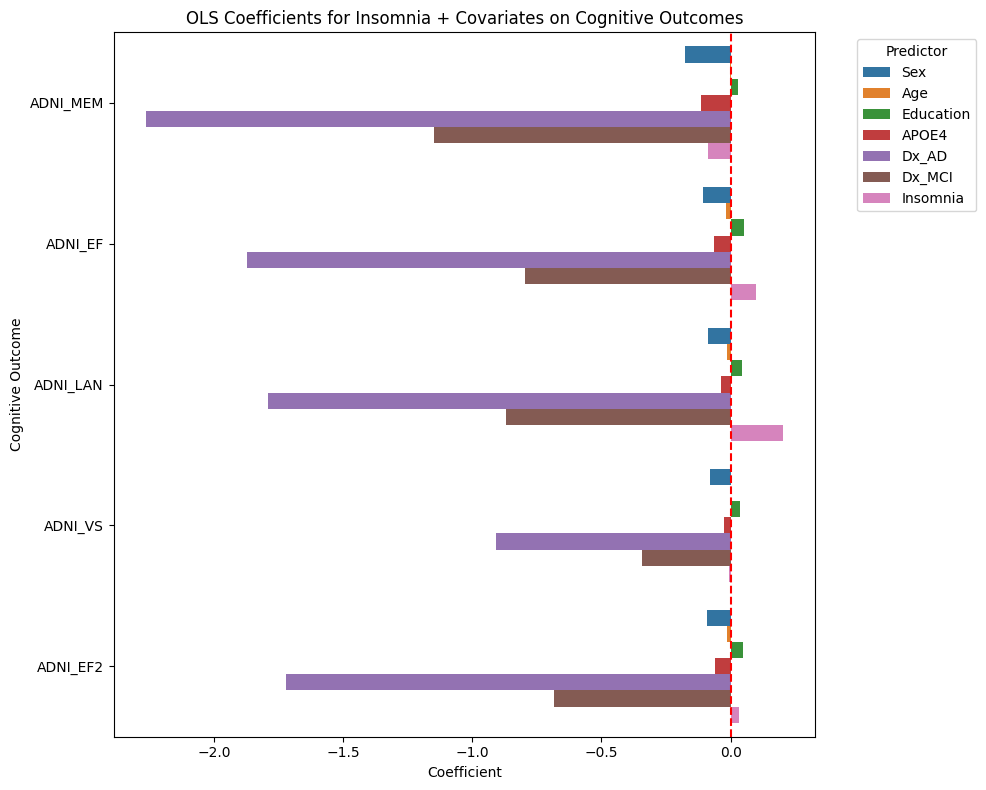

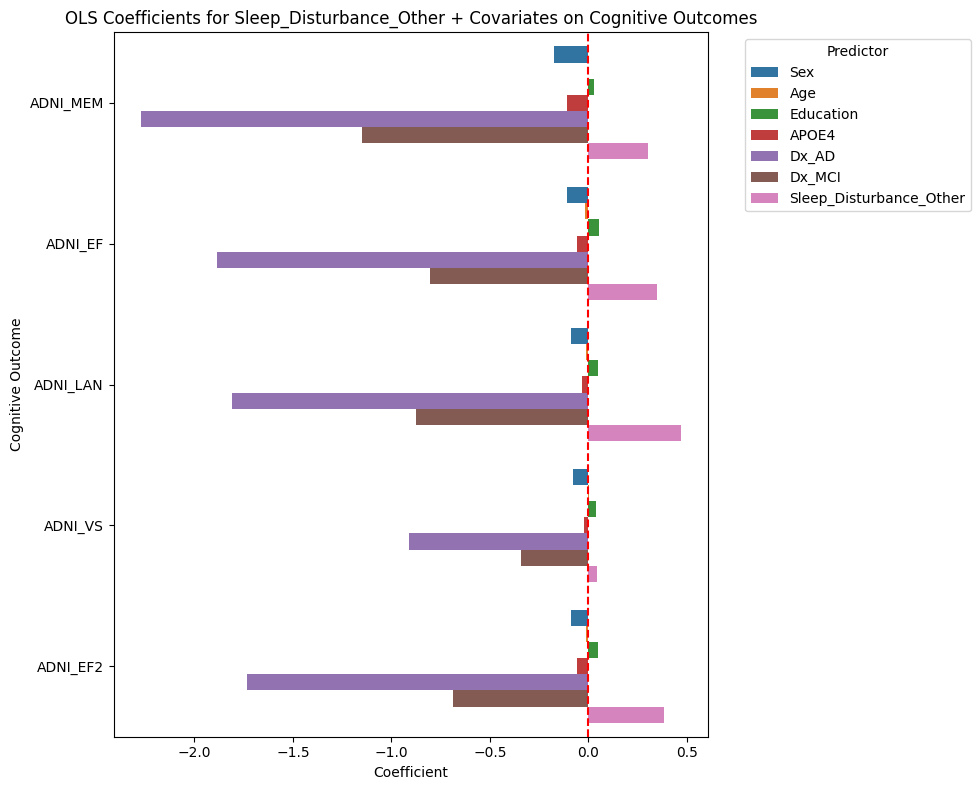

In [65]:
for sleep_var in flat_cog['Sleep_Variable'].unique():
    df_plot = flat_cog[flat_cog['Sleep_Variable'] == sleep_var]

    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df_plot,
        x='Coefficient',
        y='Outcome',
        hue='Feature',
        dodge=True,
        palette='tab10'
    )

    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(
        f'OLS Coefficients for {sleep_var} + Covariates on Cognitive Outcomes')
    plt.xlabel('Coefficient')
    plt.ylabel('Cognitive Outcome')
    plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()